In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym

In [2]:
beg = 1234
train_env = gym.make('LunarLander-v3', render_mode=None)
test_env = gym.make('LunarLander-v3', render_mode=None)
train_env.reset(seed=beg)
test_env.reset(seed=beg + 1)
np.random.seed(beg)
torch.manual_seed(beg)

In [3]:
# Define MLP class
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        self.actor = actor
        self.critic = critic

    def forward(self, state):
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        return action_pred, value_pred

In [5]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

policy = ActorCritic(actor, critic)

In [6]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)


In [7]:
policy.apply(init_weights)

ActorCritic(
  (actor): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (critic): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [8]:
LEARNING_RATE = 0.0005

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

In [10]:
def train(env, policy, optimizer, discount_factor, ppo_steps, ppo_clip):
    policy.train()
    states = []
    actions = []
    log_prob_actions = []
    values = []
    rewards = []
    
    done = False
    episode_reward = 0

    state, _ = env.reset()
    
    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Convert state to tensor
        
        # Store state before taking action
        states.append(state_tensor)

        action_pred, value_pred = policy(state_tensor)
        action_prob = F.softmax(action_pred, dim=-1)
        dist = distributions.Categorical(action_prob)
        
        action = dist.sample()
        log_prob_action = dist.log_prob(action)
        
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        
        actions.append(action)
        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)

        episode_reward += reward
        state = next_state
        
        # Combine terminated and truncated flags to determine if the episode is done
        done = terminated or truncated

    # Convert lists to tensors for processing
    states = torch.cat(states)
    actions = torch.cat(actions)
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)

    # Calculate returns and advantages
    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns.detach(), values.detach())

    # Update policy using PPO steps
    policy_loss, value_loss = update_policy(
        policy,
        states,
        actions,
        log_prob_actions,
        advantages,
        returns,
        optimizer,
        ppo_steps,
        ppo_clip,
    )

    return policy_loss, value_loss, episode_reward

In [11]:
def calculate_returns(rewards, discount_factor, normalize=True):
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)

    returns = torch.tensor(returns)
    
    if normalize:
        if returns.std() > 0:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    
    return returns

In [12]:
def calculate_advantages(returns, values, normalize=True):
    advantages = returns - values
    
    if normalize:
        if advantages.std() > 0:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    return advantages


In [13]:
def update_policy(policy, states, actions, log_prob_actions, advantages, returns, optimizer, ppo_steps, ppo_clip):
    
    total_policy_loss = 0 
    total_value_loss = 0
    
    states = states.detach()
    actions = actions.detach()
    log_prob_actions = log_prob_actions.detach()
    advantages = advantages.detach()
    returns = returns.detach()
    
    for _ in range(ppo_steps):
                
        #get new log prob of actions for all input states
        action_pred, value_pred = policy(states)
        value_pred = value_pred.squeeze(-1)
        action_prob = F.softmax(action_pred, dim = -1)
        dist = distributions.Categorical(action_prob)
        
        #new log prob using old actions
        new_log_prob_actions = dist.log_prob(actions)
        
        policy_ratio = (new_log_prob_actions - log_prob_actions).exp()
                
        policy_loss_1 = policy_ratio * advantages
        policy_loss_2 = torch.clamp(policy_ratio, min = 1.0 - ppo_clip, max = 1.0 + ppo_clip) * advantages
        
        policy_loss = - torch.min(policy_loss_1, policy_loss_2).mean()
        
        value_loss = F.smooth_l1_loss(returns, value_pred).mean()
    
        optimizer.zero_grad()

        policy_loss.backward()
        value_loss.backward()

        optimizer.step()
    
        total_policy_loss += policy_loss.item()
        total_value_loss += value_loss.item()
    
    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps

In [14]:
# Evaluate function with updated Gymnasium API handling
def evaluate(env, policy):
    policy.eval()
    rewards = []
    done = False
    episode_reward = 0

    # Reset environment and unpack observation
    state, _ = env.reset()

    while not done:
        # Convert state to tensor
        state_tensor = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
            action_pred, _ = policy(state_tensor)
            action_prob = F.softmax(action_pred, dim=-1)

        # Select action with highest probability
        action = torch.argmax(action_prob, dim=-1)

        # Step through environment and unpack results
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward

        # Update state and check if episode is done
        state = next_state
        done = terminated or truncated

    return episode_reward

In [15]:
MAX_EPISODES = 1_000
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 200
PRINT_EVERY = 10
PPO_STEPS = 5
PPO_CLIP = 0.2

train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES + 1):
    # Train policy on train_env
    policy_loss, value_loss, train_reward = train(
        train_env, policy, optimizer, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP
    )

    # Evaluate policy on test_env
    test_reward = evaluate(test_env, policy)

    # Append rewards for tracking performance
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)

    # Calculate mean rewards over last N_TRIALS episodes
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])

    # Print progress every PRINT_EVERY episodes
    if episode % PRINT_EVERY == 0:
        print(
            f"| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:7.1f} | Mean Test Rewards: {mean_test_rewards:7.1f} |"
        )

    # Stop training if reward threshold is reached
    if mean_test_rewards >= REWARD_THRESHOLD:
        print(f"Reached reward threshold in {episode} episodes")
        break

| Episode:  10 | Mean Train Rewards:  -159.0 | Mean Test Rewards:  -843.8 |
| Episode:  20 | Mean Train Rewards:  -136.6 | Mean Test Rewards:  -673.3 |
| Episode:  30 | Mean Train Rewards:  -118.6 | Mean Test Rewards:  -750.8 |
| Episode:  40 | Mean Train Rewards:   -96.8 | Mean Test Rewards:  -766.8 |
| Episode:  50 | Mean Train Rewards:   -99.1 | Mean Test Rewards:  -964.3 |
| Episode:  60 | Mean Train Rewards:   -89.3 | Mean Test Rewards:  -778.8 |
| Episode:  70 | Mean Train Rewards:   -80.3 | Mean Test Rewards:  -593.3 |
| Episode:  80 | Mean Train Rewards:   -70.6 | Mean Test Rewards:  -606.5 |
| Episode:  90 | Mean Train Rewards:   -43.7 | Mean Test Rewards:  -561.9 |
| Episode: 100 | Mean Train Rewards:   -60.0 | Mean Test Rewards:  -771.9 |
| Episode: 110 | Mean Train Rewards:   -41.9 | Mean Test Rewards:  -702.0 |
| Episode: 120 | Mean Train Rewards:   -58.0 | Mean Test Rewards:  -542.4 |
| Episode: 130 | Mean Train Rewards:   -50.0 | Mean Test Rewards:  -403.4 |
| Episode: 1

In [16]:
torch.save(policy.state_dict(), "lunar_lander_policy.pth")

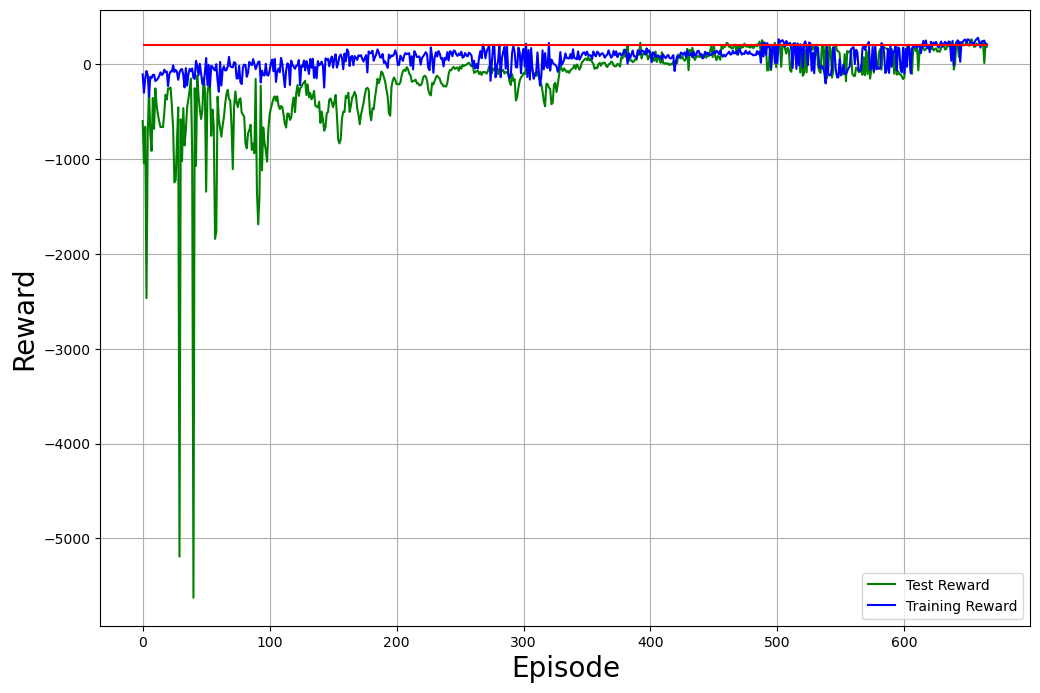

In [21]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward', color='g')
plt.plot(train_rewards, label='Training Reward', color='b')
plt.xlabel('Episode', fontsize=20,)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()